In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.affinity import rotate, translate

import numpy as np
import math

import matplotlib.pyplot as plt

In [ ]:
poly_path = 'ancillary_data/poly_utm.gpkg'

In [ ]:
poly = gpd.read_file(poly_path)
poly.head()

In [ ]:
# length = 25
# wide = 25

# cols = list(np.arange(xmin, xmax + wide, wide))
# rows = list(np.arange(ymin, ymax + length, length))

# polygons = []
# for x in cols[:-1]:
#     for y in rows[:-1]:
#         polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))


# contained_polygons = []

# for i in polygons:
#     if poly.contains(i).values==True:
#         contained_polygons.append(i)

# grid = gpd.GeoDataFrame({'geometry':contained_polygons}, crs='EPSG:32319')

# covered_area = round((sum(grid.area.values)/poly.area*100).values[0], 2)
# print('Covered area or input polygon: {}%'.format(covered_area))

# grid.to_file("grid.shp")

In [ ]:
def grid_within(input_poly, length, width, crs):
    "Makes a grid within an input polygon"
    xmin, ymin, xmax, ymax = input_poly.total_bounds
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]))


    contained_polygons = []
    for i in polygons:
        if input_poly.contains(i).values==True:
            contained_polygons.append(i)
    
    try:
        grid = gpd.GeoDataFrame({'geometry': contained_polygons}, crs=crs)
    except:
        print('Conversion to GeoDataFrame failed.')

    covered_area = round((sum(grid.area.values)/input_poly.area*100).values[0], 2)
    print('Covered area of input polygon: {}%'.format(covered_area))
    
    return grid

In [ ]:
# with smaller cells sizes more area gets covered
grilla = grid_within(poly, 100, 100, 'EPSG:32319')
# grilla.to_file("subproducts/opt1_grid_100x100.gpkg", driver="GPKG", layer='grid100x100')

In [ ]:
16326326.171748962/poly.area*100

### Rotate grid

In [ ]:
geom = MultiPolygon(grilla.geometry.values)
rotated = list(rotate(geom, -9))
grilla_rot = grilla.copy()
grilla_rot['geometry'] = rotated
grilla_rot.to_file("grid_rotated_100x100.shp")

In [ ]:
length=200
width=200
crs='EPSG:32319'

xmin, ymin, xmax, ymax = poly.total_bounds
ymin = ymin - ymin*0.0005
xmin = xmin - xmin*0.02
xmax = xmax + xmax*0.02
ymax = ymax + ymax*0.0005

cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + length, length))
    
polygons = []

for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]))

In [ ]:
def make_grid(input_poly, length, width, crs):
    "Makes a grid that covers a polygon"
    xmin, ymin, xmax, ymax = poly.total_bounds
    ymin = ymin - ymin*0.0003
    xmin = xmin - xmin*0.015
    xmax = xmax + xmax*0.015
    ymax = ymax + ymax*0.0003

    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]))
    
    try:
        grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
    except:
        print('Conversion to GeoDataFrame failed.')

    return grid

In [ ]:
grid = make_grid(poly, 100, 100, 'EPSG:32319')

In [ ]:
grid.to_file("grid_100x100.shp")

In [ ]:
(poly.centroid.x[0], poly.centroid.y[0])

In [ ]:
def rotate_grid(geodf, anchor_polygon, angle):
    geom = MultiPolygon(geodf.geometry.values)
    rotated = list(rotate(geom, angle, origin=(anchor_polygon.centroid.x[0], anchor_polygon.centroid.y[0])))
    return rotated

In [ ]:
grilla_rot = grid.copy()
grilla_rot['geometry'] = rotate_grid(grid, poly, -42.677888582930166)
grilla_rot.to_file("grid_rotated_100x100.shp")

In [ ]:
def depurate_grid(grid_geom, input_poly):
    contained_polygons = []
    for i in grid_geom:
        if input_poly.contains(i).values==True:
            contained_polygons.append(i)

    try:
        grid = gpd.GeoDataFrame({'geometry': contained_polygons}, crs=crs)
    except:
        print('Conversion to GeoDataFrame failed.')
        
    return grid

In [ ]:
grilla_rot_depu = depurate_grid(grilla_rot['geometry'], poly)
grilla_rot_depu.to_file("grid_rotated_depu_100x100.shp")

In [ ]:
covered_area = round((sum(grilla_rot_depu.area.values)/poly.area*100).values[0], 2)
print('Covered area or input polygon: {}%'.format(covered_area))

### Creates rotated grid

In [ ]:
print(geom.minimum_rotated_rectangle)

In [ ]:
geom = poly.geometry.values[0]
poly_bb = poly.copy()
poly_bb['geometry'] = geom.minimum_rotated_rectangle

In [ ]:
print(geom)

In [ ]:
poly_bb.to_file("subproducts/poly_bb.gpkg", driver="GPKG", layer='bb')

In [ ]:
poly_bb_boundary = geom.minimum_rotated_rectangle.boundary
print(poly_bb_boundary)

# calcs angle
coords = [c for c in poly_bb_boundary.coords]
segments = [LineString([a, b]) for a, b in zip(coords,coords[1:])]
longest_segment = max(segments, key=lambda x: x.length)

p1, p2 = [c for c in longest_segment.coords]

angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
#https://stackoverflow.com/questions/42258637/how-to-know-the-angle-between-two-points

angle_rot = (90-angle)
angle_rot

In [ ]:
def get_angle(geom):
    "Gets the angle of the minimum oriented bounding box of a polygon"
    # minumim oriente bounding box
    mobb = geom.minimum_rotated_rectangle.boundary
    # calcs angle
    coords = [c for c in mobb.coords]
    segments = [LineString([a, b]) for a, b in zip(coords,coords[1:])]
    longest_segment = max(segments, key=lambda x: x.length)

    p1, p2 = [c for c in longest_segment.coords]

    angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))

    angle_rot = (90-angle)
    return angle_rot

In [ ]:
get_angle(poly.geometry[0])

In [ ]:
# rotates polygon BB
geom_bb = poly_bb['geometry'][0]
rotated = rotate(geom_bb, angle_rot, origin=(geom_bb.centroid.x, geom_bb.centroid.y))
print(rotated)

In [ ]:
crs = 'EPSG:32319'
poly_bb_rot = gpd.GeoDataFrame({'geometry': rotated}, crs=crs, index=[0])
# poly_bb_rot.to_file("subproducts/poly_bb_rot_100x100.gpkg", driver="GPKG", layer='poly_bb_rot_100x100')
poly_bb_rot

In [ ]:
grid_rot = grid_within(poly_bb_rot, 100, 100, crs)
grid_rot.to_file("subproducts/grid_rot_100x100.gpkg", driver="GPKG", layer='grid_rot_100x100')

In [ ]:
# rotates back to original position
geom = rotate_grid(grid_rot, poly_bb, -angle_rot)
grilla_rot_back = gpd.GeoDataFrame({'geometry': geom}, crs=crs)
grilla_rot_back.to_file("grid_rotated_back_100x100.shp")

In [ ]:
# rotates polygon
geom = poly['geometry'][0]
rotated = rotate(geom, angle_rot, origin=(geom.centroid.x, geom.centroid.y))
print(rotated)

In [ ]:
gpd.GeoSeries(rotated).plot()
plt.show()

In [ ]:
poly_rotated = gpd.GeoDataFrame({'geometry': rotated}, crs=crs, index=[0])
# poly_rotated.to_file("subproducts/poly_rotated.gpkg", driver="GPKG", layer='poly_rotated')

In [ ]:
grid_rot = grid_within(poly_rotated, 100, 100, crs)

In [ ]:
geom = rotate_grid(grid_rot, poly, -angle_rot)
grilla_rot_back = gpd.GeoDataFrame({'geometry': geom}, crs=crs)

grilla_rot_back.to_file("subproducts/grid_rotated_depu_2_100x100.gpkg", driver="GPKG", layer='grid_rot_2_100x100')

### Optimize grid overlapping

In [ ]:
length = 100
width = 100
iterations = 12
meters_gap = 2
crs = 'EPSG:32319'
angle = get_angle(poly.geometry[0])
print(angle)

# mobb
mobb = poly.geometry[0].minimum_rotated_rectangle.boundary

# rotates polygon
rotated = rotate(mobb, angle, origin=(mobb.centroid.x, mobb.centroid.y))


In [ ]:
def rotate_grid(geom, anchor_polygon, angle):
    multi_geom = MultiPolygon(geom)
    rotated = list(rotate(multi_geom, angle, origin=(anchor_polygon.centroid.x[0], anchor_polygon.centroid.y[0])))
    return rotated

In [ ]:
length = 50
width = 50
iterations = 10
meters_gap = 1
crs = 'EPSG:32319'
angle = get_angle(poly.geometry[0])
print('Rotation angle: ', angle)

# mobb
# mobb = poly.geometry[0].minimum_rotated_rectangle

# rotates polygon
rotated = rotate(poly.geometry[0], angle, origin=(poly.geometry[0].centroid.x, poly.geometry[0].centroid.y))

xmin, ymin, xmax, ymax = rotated.bounds
ymin = ymin - ymin*0.0005
xmin = xmin - xmin*0.02
xmax = xmax + xmax*0.02
ymax = ymax + ymax*0.0005

cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]))

buffered_polygon = rotated.buffer(length*2)
        
intersected_polygons = []

for i in polygons:
    if buffered_polygon.intersects(i)==True:
        intersected_polygons.append(i)

intersected_polygons = gpd.GeoDataFrame({'geometry': intersected_polygons}, crs=crs)
    
translated = []

for i in range(0, iterations * meters_gap, meters_gap):
    _trans = intersected_polygons.geometry.apply(lambda x: translate(x, xoff=i, yoff=-i))
    translated.append(_trans)

grids = []

for grid in translated:
    contained_polygons = []
    for i in grid:
        if rotated.contains(i)==True:
            contained_polygons.append(i)
    grids.append(contained_polygons)

grids_len = [len(i) for i in grids]
optimal = grids_len.index(max(grids_len))
grid_optimized = grids[optimal]

grid_optimized_back = rotate_grid(grid_optimized, -angle, poly)

final_grid = gpd.GeoDataFrame({'geometry': grid_optimized_back}, crs=crs)

covered_area = round((sum(final_grid.area.values)/poly.area*100).values[0], 2)
print('Covered area or input polygon: {}%'.format(covered_area))

In [ ]:
final_grid.to_file("subproducts/translated_4.gpkg", driver="GPKG", layer='trans')

## Function developing

In [7]:
def read_data(path):
    try:
        data = gpd.read_file(path)
        print('Input data loaded successfully')
    except:
        print('Data loading failed')
    return data


# analyze potential for generalization
def get_angle(geom):
    "Gets the angle of the minimum oriented bounding box of a polygon"
    # gets the minimum oriented bounding box
    mobb = geom.minimum_rotated_rectangle.boundary
    # calcs angle
    coords = [c for c in mobb.coords]
    segments = [LineString([a, b]) for a, b in zip(coords,coords[1:])]
    # gets the longest segment
    longest_segment = max(segments, key=lambda x: x.length)
    # calcs angle
    p1, p2 = [c for c in longest_segment.coords]
    angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
    angle_rot = (90-angle)
    
    return angle_rot


def make_grid(geom, length, width, crs):
    "Makes a grid that covers a input geometry"
    xmin, ymin, xmax, ymax = geom.bounds

    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]))

    return polygons


def rotate_grid(geom, angle, anchor_geom):
    "Rotates a geometry grid at a given angle with given polygon to use its centroid as anchor point"
    multi_geom = MultiPolygon(geom)
    rotated = rotate(multi_geom, angle, origin=(anchor_geom.centroid.x, anchor_geom.centroid.y))
    return list(rotated)


def rotate_polygon(geom, angle, anchor_geom):
    rotated = rotate(geom, angle, origin=(anchor_geom.centroid.x, anchor_geom.centroid.y))
    return rotated

In [8]:
def optimal_grid(path, length, width, iterations, meters_gap, crs):
    """
    :path: string
    :length: int or real
    :widht: int or real
    :iterations: int
    :meters_gap: int or real
    :crs: string
    """
    if length < 10 or width < 10:
        raise Exception("The minimum width and length is 10 meters")
    
    if iterations < 2 or iterations > 200:
        raise Exception("The iterations parameter has to be an integer between 2 and 200")
        
    if meters_gap < 0:
        raise Exception("The meters_gap parameter has to be positive")

    # reads data
    poly = read_data(path)
    
    # gets geom in shapely format
    poly_geometry = poly.geometry[0]
    
    # cell size check
    if poly_geometry.area < (length/width)*3:
        raise Exception('''The area of the cells of grid has to be at
        least 3 times bigger than the area of the polygon''')
    
    # calcs angle
    try:
        angle = get_angle(poly_geometry)
        print('Angle of the input geometry: {} grades'.format(round(angle, 2)))
    except:
        print('Angle calculation failed')
    
    # rotates polygon
    try:
        rotated = rotate_polygon(poly_geometry, angle, poly_geometry)
    except:
        print('Rotation of input polygon failed')

    # buffers original polygon
    try:
        buffered_polygon = rotated.buffer(length*4)
    except:
        print('Buffering of rotated input polygon failed.')
        
    # makes grid
    try:
        _grid = make_grid(buffered_polygon, length, width, crs)
    except:
        print('Initial grid creation failed')
        
    try:
        _grid = rotate_grid(_grid, -angle, poly)
        _grid_gdf = gpd.GeoDataFrame({'geometry': _grid}, crs=crs)
    except:
        print('Grid rotation failed')
    
    # generates copies of the grid translated by the meters_gap parameter
    translated = []
                        
    for i in range(-1, iterations):
        _move = i + meters_gap
        _trans = _grid_gdf.geometry.apply(lambda x: translate(x, xoff=_move, yoff=-_move))
        translated.append(_trans)

    # keeps the geometries that are inside the original polygon
    grids = []

    for grid in translated:
        contained_polygons = []
        for i in grid:
            if poly_geometry.contains(i)==True:
                contained_polygons.append(i)
        grids.append(contained_polygons)

    # picks the grid that covers more area of the input polygon
    # and converts it to geodataframe
    try:
        grids_len = [len(i) for i in grids]
        optimal = grids_len.index(max(grids_len))
        grid_optimized = grids[optimal]
        gdf_grid = gpd.GeoDataFrame({'geometry': grid_optimized}, crs=crs)
    except:
        print('Optimization failed')

    # calculates the covered area
    try:
        dissolved_grid = gdf_grid.dissolve()
        symdiff = gpd.overlay(dissolved_grid, poly, how='symmetric_difference')
        symdiff_area = sum(symdiff.area)
        uncovered_area = (symdiff_area/poly.area*100).values[0]
        covered_area = 100 - uncovered_area
        print("""Covered area: {}%""".format(round(covered_area,2)))
    except:
        print('Calculation of covered area failed')
              
    return gdf_grid

In [11]:
path = 'ancillary_data/poly_utm.gpkg'
length = 100
width = 100
iterations = 50
meters_gap = 0.5
crs = 'EPSG:32319'

resulting_grid = optimal_grid(path, length, width, iterations, meters_gap, crs)

Input data loaded successfully
Angle of the input geometry: 42.68 grades
Covered area: 95.46%


<AxesSubplot:>

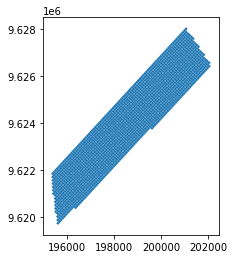

In [12]:
resulting_grid.plot()

100x100x1x1= 90.66%
100x100x2x1= 95.46%

In [2]:
path = 'ancillary_data/poly_utm.gpkg'
length = 100
width = 100
iterations = 5
meters_gap = 1
crs = 'EPSG:32319'

# save 
resulting_grid = optimal_grid(path, length, width, iterations, meters_gap, crs)

NameError: name 'optimal_grid' is not defined

In [ ]:
resulting_grid.plot()

In [ ]:
resulting_grid.to_file("tests/test_6.gpkg", driver="GPKG", layer='test')